In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import configparser
import json
import requests
import xmltodict
from bs4 import BeautifulSoup
import time
import pickle
import os
import gensim
import csv
import seaborn as sns
import smart_open
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore')

# retrieve episode descriptions

In [3]:
fname = 'feed.xml'
url = 'http://dataskeptic.com/feed.rss'

if not(os.path.isfile(fname)):
    print('fetching')
    r = requests.get(url)
    f = open(fname, 'wb')
    f.write(r.text.encode('utf-8'))
    f.close()

with open(fname) as fd:
    xml = xmltodict.parse(fd.read())

In [4]:
test = xml['rss']['channel']['item'][72]['description']
a = BeautifulSoup(test,'lxml').text
a

'Bargaining is the process of two (or more) parties attempting to\nagree on the price for a transaction. \xa0Game theoretic\napproaches attempt to find two strategies from which neither party\nis motivated to deviate. \xa0These strategies are said to be in\nequilibrium with one another. \xa0The equilibriums available in\nbargaining depend on the the transaction mechanism and the\ninformation of the parties. \xa0Discounting (how long parties are\nwilling to wait) has a significant effect in this process.\n\xa0This episode discusses some of the choices Kyle and Linh Da\nmade in deciding what offer to make on a house.'

In [5]:
episodes = xml['rss']['channel']['item']
descriptions = []
descToTitle = {}
descToLink = {}
descToNum = {}
l = len(episodes)
for episode in episodes:
    enclosure = episode['enclosure']
    
    desc = episode['description']
    desc = desc.replace(u'\xa0', u' ')
    desc = desc.replace(u'\n', u' ')
    desc = desc.replace(u'\xc2', u' ')

    
    desc = BeautifulSoup(desc, "lxml").text
    descriptions.append(desc)
    
    descToTitle[desc] = episode['title']
    descToLink[desc] = episode['link']
    descToNum[desc] = l
    l = l - 1

In [6]:
episodes[0].keys()

odict_keys(['title', 'pubDate', 'guid', 'link', 'itunes:image', 'description', 'content:encoded', 'enclosure', 'itunes:duration', 'itunes:explicit', 'itunes:keywords', 'itunes:subtitle', 'itunes:episodeType'])

In [7]:
for desc in descriptions:
    print(descToNum[desc])
    print(descToTitle[desc])
    print(descToLink[desc])    

178
[MINI] One Shot Learning
https://dataskeptic.com/blog/episodes/2017/one-shot-learning
177
Recommender Systems Live from FARCON 2017
https://dataskeptic.com/blog/episodes/2017/recommender-systems-live-from-farcon
176
[MINI] Long Short Term Memory
https://dataskeptic.com/blog/episodes/2017/long-short-term-memory
175
Zillow Zestimate
https://dataskeptic.com/blog/episodes/2017/zillow-zestimate
174
Cardiologist Level Arrhythmia Detection with CNNs
https://dataskeptic.com/blog/episodes/2017/cardiologist-level-arrhythmia-detection-with-cnns
173
[MINI] Recurrent Neural Networks
https://dataskeptic.com/blog/episodes/2017/recurrent-neural-networks
172
Project Common Voice
https://dataskeptic.com/blog/episodes/2017/project-common-voice
171
[MINI] Bayesian Belief Networks
http://dataskeptic.com/blog/episodes/2017/bayesian-belief-networks
170
pix2code
https://dataskeptic.com/blog/episodes/2017/pix2code
169
[MINI] Conditional Independence
http://dataskeptic.com/blog/episodes/2017/conditional-ind

# Save description in txt file.

In [22]:
thefile = open('./text/episode_descs.txt', 'w')

for i, desc in enumerate(descriptions):
    desc = desc.encode('utf-8').strip()
    desc = "*"+ str(i)+str(desc).replace('\n', "") 
    thefile.write("%s\n" % desc)
    
    

In [23]:
with open('./text/episode_descs.txt', 'r') as f:
    i=0
    for line in f:
        i+=1
        print(i)
        print(line[0:30])

1
*0b'One Shot Learning is the c
2
*1b'Recommender systems play a
3
*2b'Thanks to our sponsor bril
4
*3b'Zillow is a leading real e
5
*4b'Our guest Pranav Rajpurkar
6
*5b'RNNs are a class of deep l
7
*6b"Thanks to our sponsor Spri
8
*7b"A Bayesian Belief Network 
9
*8b'In this episode, Tony Belt
10
*9b"In statistics, two random 
11
*10b'Animals can\'t tell us wh
12
*11b'This episode collects int
13
*12b'This episode discusses th
14
*13b'hen faced with medical is
15
*14b'In a neural network, the 
16
*15b'This episode recaps the M
17
*16b"Max-pooling is a procedur
18
*17b'This episode is an interv
19
*18b"CNNs are characterized by
20
*19b"Despite the success of GA
21
*20b"GANs are an unsupervised 
22
*21b'Recently, we\'ve seen opi
23
*22b"No reliable, complete dat
24
*23b'There\'s more than one ty
25
*24b'Backpropagation is a comm
26
*25b"In this week's episode of
27
*26b"Feed Forward Neural Netwo
28
*27b'In this Data Skeptic epis
29
*28b"Today's episode overviews
30
*29b'DataRefuge is a

In [24]:
i # it should be 178 before 9/28/2017.

178

# Use the word vectors trained from SO to represent episode descriptions.

## get word vectors trained from SO

In [25]:
key = 'word2vector_model_question_answer_200_6_2'
fname = './word_vec/'+key+".csv"
word_vecs_df = pd.read_csv(fname,index_col=0)
word_vecs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
a_,-0.713271,-0.077981,0.010418,-0.697069,-2.598913,-1.080629,-1.033209,0.885287,0.872299,-1.011196,...,0.674927,0.418498,-0.977101,-1.157536,-0.027437,-0.224027,-0.545397,-0.176365,2.447978,0.182951
a__,0.013685,-0.000013,-0.025492,-0.012469,-0.009770,-0.009924,-0.004867,0.006001,0.038898,-0.027364,...,0.053458,0.000878,0.002365,-0.048481,-0.054677,-0.030503,-0.012346,0.029457,0.056696,-0.029260
a_a,0.020415,0.156389,-0.060513,-0.028313,-0.116366,-0.042931,-0.130101,-0.006461,0.008261,-0.065245,...,-0.067757,0.007425,-0.111685,0.160803,0.014258,-0.012060,0.078916,0.054315,0.021641,-0.026724
a_adjusted,-0.046735,0.041834,-0.061836,0.021160,0.046803,-0.024107,-0.032979,0.053604,0.037605,-0.080140,...,0.083108,-0.026857,0.024127,0.040530,-0.040803,-0.038954,0.027903,0.024604,-0.021590,-0.051460
a_after_est,-0.011185,0.017912,-0.080105,-0.030186,0.052851,-0.022680,-0.036077,0.007863,-0.008886,-0.044048,...,0.066457,-0.011853,-0.007649,0.017082,-0.006570,-0.020994,0.003839,0.006295,-0.008900,-0.035567


In [26]:
vocab = word_vecs_df.index
len(vocab)

100269

In [27]:
fname = './vocab_dict/vocab_dict_question_answer_200_6_2.csv'
with open(fname, 'r') as csv_file:
    reader = csv.reader(csv_file)
    vocab_dic = dict(reader)

In [28]:
for k, value in vocab_dic.items():
    vocab_dic[k] = int(value)
    

In [29]:
vocab_dic['a_']

0

# Preprocessing the text in episode descriptions

In [30]:
def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                
                yield gensim.utils.simple_preprocess(line)
                #This lowercases, tokenizes, de-accents (optional). – the output are final tokens = unicode strings, that won’t be processed any further.
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])


In [31]:

fname = './text/episode_descs.txt'
episode_desc_corpus = list(read_corpus(fname, tokens_only= True))

In [32]:
corpus = []
for desc in episode_desc_corpus:
    corpus.append(" ".join(desc))

In [33]:
len(corpus) 

178

# Get tf_idf features of episode descriptions

In [34]:
vectorizer = TfidfVectorizer(min_df=1,vocabulary = vocab_dic)
X = vectorizer.fit_transform(corpus)


Note: [vocabulary] Mapping or iterable, optional
Either a Mapping (e.g., a dict) where keys are terms and values are indices in the feature matrix, or an iterable over terms. If not given, a vocabulary is determined from the input documents.

Which words are in episode descriptions but not in the vocab of SO?


In [35]:
# What words are not in SO?
for i in range(178):
#     print(len(X[i,:].nonzero()[1]))
#     print(len(set(corpus[i].split(' '))))
    diff = set(corpus[i].split(' ')).difference(set(vocab))
    if len(diff) >5:
        print('*******************************************************')
        print(i)
        print(diff)  
        print(descriptions[i])

*******************************************************
22
{'jawbone', 'rosevere', 'aglpjrmp', 'zehr', 'blueplastic', 'dashboarding', 'zareen', 'periscopedata', 'joytafty', 'openhouse', 'iamzareenf'}
No reliable, complete database cataloging home sales data at a transaction level is available for the average person to access. To a data scientist interesting in studying this data, our hands are complete tied. Opportunities like testing sociological theories, exploring economic impacts, study market forces, or simply research the value of an investment when buying a home are all blocked by the lack of easy access to this dataset. OpenHouse seeks to correct that by centralizing and standardizing all publicly available home sales transactional data. In this episode, we discuss the achievements of OpenHouse to date, and what plans exist for the future.     Check out the OpenHouse gallery.    I also encourage everyone to check out the project Zareen mentioned which was her Harry Potter word2

*******************************************************
102
{'atheist', 'bandcamp', 'gonz_blinko', 'refreshable', 'chrishofstader', 'skepchick', 'shelley', 'skeptibility', 'nomads', 'activist', 'tenon', 'hofstader', 'braille', 'dqtech'}
Today's guest is Chris Hofstader (@gonz_blinko), an accessibility researcher and advocate, as well as an activist for causes such as improving access to information for blind and vision impaired people. His background in computer programming enabled him to be the leader of JAWS, a Windows program that allowed people with a visual impairment to read their screen either through text-to-speech or a refreshable braille display. He's the Managing Member of 3 Mouse Technology. He's also a frequent blogger primarily at chrishofstader.com. For web developers and site owners, Chris recommends two tools to help test for accessibility issues: tenon.io and dqtech.co. A guest post from Chris appeared on the Skepchick blogged titled Skepticism and Disability which le

In [36]:
X.shape

(178, 100269)

# Get weighted doc vectors for all episode description

In [ ]:
i=0
episode_desc_corpus[i]

### How to get the weighted vectors of the episode descriptions?

....


<img src="pictures/tf_idf_matrix.png">
<img src="pictures/word_vec_df.png">


- For example, doc has three words: doc = [word1, word2, word3].
- vec_word_i = [d1, d2, ..., dn] 
- n = size in hidden layer.

- tf_idf_ji = tf_idf of word i in doc_j; Scale them such that sum_i tf_idf_ji = 1. 

- Then the vector of doc_j = sum_i (vec_word_i * tf_dif_ji) which is a vector with the same len as vec_word_i.

In [37]:
def get_doc_weighted_vec(i, doc_corpus , tf_idf = X, weighted = True): # ith documents. doc_corpus a list of words
    
    df = word_vecs_df 
    related_rows = df.loc[sorted(list(set(doc_corpus).intersection(set(vocab)))), :] 
    
    if weighted:
        weights = []
        ind = sorted(tf_idf[i,:].nonzero()[1])
        if sum([vectorizer.vocabulary_[related_rows.index[j]] != ind[j] for j in range(len(ind))]) != 0:
            print("words position don't match")
            return 
        for j in ind:
            weights.append(tf_idf[i,j])
        weights = np.array(weights)/sum(weights)
    else:
        weights = [1/related_rows.shape[0]] * related_rows.shape[0]
    
    if related_rows.shape[0] != len(weights):
        print(i)
        print(related_rows.shape[0])
        print(len(weights))
    
    result = related_rows.T * weights
    return result.sum(axis = 1)

In [38]:
episode_vec_weighted = []
total = len(descriptions)
for i in range(total):
    doc_corpus = episode_desc_corpus[i]
    episode_vec_weighted.append(get_doc_weighted_vec(i,doc_corpus))


### Save the episode weighted vectors

In [39]:
def save_obj(obj, name ):
    with open('episode_vec/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open('episode_vec/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [40]:
save_obj(episode_vec_weighted, "episode_vec_weighted")


In [41]:
episode_vec_weighted_df = pd.DataFrame(episode_vec_weighted)
episode_vec_weighted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.321742,-0.091622,1.020477,-0.105819,-0.154422,0.356765,-0.185670,0.368219,0.242798,-0.084168,...,0.051760,0.202284,0.269600,0.152225,0.290375,0.030409,-0.216377,-0.123192,-0.171273,-0.096611
1,0.299671,0.405244,0.184728,-0.109321,-0.225838,-0.050448,-0.330242,0.002496,0.482650,-0.160271,...,0.138463,0.477873,0.308865,-0.174514,0.092894,-0.009273,-0.265906,-0.131924,-0.161570,-0.341431
2,0.027937,0.030910,0.619684,0.278698,-0.556750,0.100715,-0.504604,0.197664,-0.160889,-0.020245,...,-0.080473,-0.403859,0.054638,-0.110568,0.197121,-0.138362,0.070910,-0.140718,0.170639,-0.120497
3,0.373949,-0.285547,0.399565,0.015362,0.009504,-0.152608,-0.271353,0.148875,0.536143,-0.274921,...,-0.116648,0.076367,0.222625,0.152811,0.032114,0.141993,-0.044989,-0.173306,-0.469663,-0.072720
4,0.357071,0.262387,0.379264,0.206661,-0.253764,-0.231780,-0.189448,0.087050,0.250881,0.023786,...,-0.267398,0.018956,0.037620,-0.261148,-0.000223,-0.194334,-0.048889,-0.305128,-0.061272,-0.238710


In [42]:
episode_vec_weighted_df.shape

(178, 200)

# Make recomendation: find related episode

## user's strings: 

some examples

In [43]:

user_requests = [
    "Could you recommend some episodes on decision tree and random forests?",
    "Can you talk about Convolutional neural network and recurrent neural network?",
    "Could you recommend some episodes on data science projects for beginners?",
    "artificial intelligence",
    "What can artificial intelligence do for human beings? What is the future of artificial intelligence?",
    "What is natural language processing? ",
    "The error percentage of regression changes with change in the train and test data which I am deciding randomly. Cross validation can overcome this but how do I apply it for my regression model?",
    "I have a precision recall curve for two separate algorithms. If I want to calculate the F-Measure I have to use the precision and recall values at a particular point on each curve. How is this point decided? For example on curve one there is a point where recall is 0.9 and precision is 0.87 and the other curve there is a point of recall at 0.95 and precision at 0.84. Alternatively, should I plot a F-measure curve for every precision recall value?",
    "Suppose I want to make predictions of a response from predictors but I have some autocorrelation in the response variable. Under OLS this would be a problem as the residuals would have autocorrelation. What if I just want to predict the response and I use regularized least squares, like lasso or ridge or elastic net? I don't care about variances of the coefficients or anything of that nature as I'm not testing any hypotheses but I feel like I might be missing something.",
    "Evaluating the quality of data.",
    "Is there any episode on Facial Recognition? How does Facial Recognition work?",
    "I am interested in knowing musical stuff.",
    "What is the trend of big data? What is big data? How to learn big data?",
    "How to learn machine learning? What books or website do you recommend?",
    "Looking for projects on criminal analysis? ",
    "How to take advantage of Internet, computer,  cloud and other  platform in an effective way?",
    "What are the most important knowledge in statistics or probability when doing machine learning?"
]  


    

## Cosine Similarity

In [44]:
all_episode = episode_vec_weighted_df.values
with open('some examples.txt', 'w') as f:
    for j in range(len(user_requests)):
        f.write("*****************************************************" + "\n")
        user_request = user_requests[j]
        user_request_corpus = gensim.utils.simple_preprocess(user_request)
        X_user = vectorizer.fit_transform([" ".join(user_request_corpus)])
        f.write(str(X_user.shape) + "\n")
        user_weighted_vec = get_doc_weighted_vec(0, user_request_corpus , tf_idf = X_user, weighted = True)
        cos_similarities = cosine_similarity(X=user_weighted_vec, Y=all_episode)

        cos_similarities = cos_similarities[0]
        cos_similarities.shape


        most_similar = cos_similarities.argsort()[-4:][::-1]
        f.write(str(most_similar) + "\n")

        threshold = 0.60
        f.write("User's request is: " + user_request + "\n" )
        for i in most_similar:

            if cos_similarities[i] > threshold:
                f.write("--------------------------"+str(cos_similarities[i])+"-----------------------------------\n")
                f.write( "\n")
                f.write(str(descToTitle[descriptions[i]]) + "\n")
                f.write(str(descToLink[descriptions[i]]) + "\n")
                f.write(str(descriptions[i].encode('utf-8')) + "\n")



    

Find the result at some example.txt.  

Since the number of all episode is handlable, let's have a look at the similarity between all episodes. By this, I also want to know the levels of the cosine similarities. 

In [45]:
A = cosine_similarity(X=all_episode)
A.shape

(178, 178)

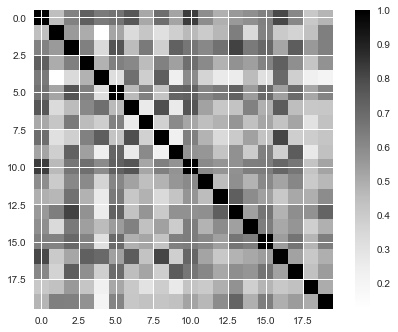

In [46]:
im = plt.imshow(A[20:40,20:40])
plt.colorbar(im)
plt.show()

# very diversity. so it is good.

## New string:

In [62]:
user_request = input('what topics are interesting to you? ')


what topics are interesting to you? I want to learn adboost tree, adboost tree, adboost tree.


In [63]:
print("Hello.", user_request)

Hello. I want to learn adboost tree, adboost tree, adboost tree.


In [64]:
# to-do: reorganize the code and write a function recommend_episode.

def recommend_episode(string):
    all_episode = episode_vec_weighted_df.values

    
    print("*****************************************************" + "\n")
    user_request = string
    user_request_corpus = gensim.utils.simple_preprocess(user_request)
    X_user = vectorizer.fit_transform([" ".join(user_request_corpus)])
    #print(str(X_user.shape) + "\n")
    user_weighted_vec = get_doc_weighted_vec(0, user_request_corpus , tf_idf = X_user, weighted = True)
    cos_similarities = cosine_similarity(X=user_weighted_vec, Y=all_episode)

    cos_similarities = cos_similarities[0]
    cos_similarities.shape


    most_similar = cos_similarities.argsort()[-4:][::-1]
    #print(str(most_similar) + "\n")

    threshold = 0.60
    print("User's request is: " + user_request + "\n" )
    for i in most_similar:

        if cos_similarities[i] > threshold:
            print("--------------------The episode has cosine similarity is "+str(cos_similarities[i])+" with user's request-------------------------\n")
            print( "\n")
            print(str(descToTitle[descriptions[i]]) + "\n")
            print(str(descToLink[descriptions[i]]) + "\n")
            print(str(descriptions[i].encode('utf-8')) + "\n")



    
    return episode

In [65]:
recommend_episode(user_request)

*****************************************************

User's request is: I want to learn adboost tree, adboost tree, adboost tree.

--------------------The episode has cosine similarity is 0.757532381884 with user's request-------------------------



[MINI] Decision Tree Learning

http://dataskeptic.com/epnotes/decision-tree-learning.php

b'Linhda and Kyle talk about Decision Tree Learning in this miniepisode.  Decision Tree Learning is the algorithmic process of trying to generate an optimal decision tree to properly classify or forecast some future unlabeled element based by following each step in the tree.'

--------------------The episode has cosine similarity is 0.601830622663 with user's request-------------------------



[MINI] Gini Coefficients

http://dataskeptic.com/blog/episodes/2016/gini-coefficient

b'The Gini Coefficient (as it relates to decision trees) is one approach to determining the optimal decision to introduce which splits your dataset as part of a decision tre

OrderedDict([('title', 'Introduction'),
             ('pubDate', 'Fri, 23 May 2014 10:00:00 +0000'),
             ('guid',
              OrderedDict([('@isPermaLink', 'false'),
                           ('#text', '80d137c5e4a81e2b34752f33db7c03c0')])),
             ('link', 'http://dataskeptic.com/epnotes/ep001.php'),
             ('itunes:image',
              OrderedDict([('@href',
                            'http://static.libsyn.com/p/assets/1/1/a/6/11a6925ea0f4027a/introduction.png')])),
             ('description',
              '<p>The Data Skeptic Podcast features conversations with topics related to data science, statistics, machine learning, artificial intelligence and the like, all from the perspective of applying critical thinking and the scientific method to evaluate the veracity of claims and efficacy of approaches.</p>\n<p>This first episode is a\xa0short discussion about what this podcast is all about.</p>'),
             ('content:encoded',
              '<p>The Data 

In [66]:
'adboost' in vocab # so no matter how many times the word 'adboost' is in the string, it won't find 

False